In [11]:
# set the directory to where the data is
# import os

# os.chdir(r"D:\Gene_Project")

In [12]:
# import warnings
# warnings.filterwarnings('ignore')

In [13]:
import os

In [14]:
os.getcwd()

'D:\\subFinder'

In [15]:
os.chdir(r'D:\\subFinder')

In [16]:
# pandas for dealing with the data
import pandas as pd
# setting for seeing the entire string
# pd.options.display.max_colwidth = None
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [17]:
data = pd.read_csv(r"Data/Supervised_Sequences/updated_data_filtered.csv")

In [29]:
data = data[data["high_level_substr"] != "capsule polysaccharide synthesis"]

In [18]:
# new_path = "D:\Gene_Project\dbCAN-PUL_07-01-2022.xlsx"

In [19]:
## load the word2vec module

In [30]:
import gensim

In [51]:
model_cbow = gensim.models.word2vec.Word2Vec.load(r"D:\subFinder\Embedding_Models_10_12\word2vec_sg") 

In [22]:
# model_cbow = gensim.models.word2vec.Word2Vec.load(r"D:\Gene_Project\word2vec_sg_sig_gene_seq") 

In [23]:
# model_fasttext_sg = gensim.models.word2vec.Word2Vec.load(r"D:\Gene_Project\model_fasttext_sg") 

In [24]:
# model_fasttext_cbow = gensim.models.word2vec.Word2Vec.load(r"D:\Gene_Project\model_fasttext_cbow") 

In [25]:
import tensorflow as tf

In [26]:
sequences = [item.replace("|", ",").replace(",", " ") for item in data["sig_gene_seq"].values]

In [27]:
data["sig_gene_seq"] = sequences

In [28]:
from Codes.Model_architectures import non_recurrent_attention_model

In [32]:
order = list(data["high_level_substr"].value_counts()[:7].index)

In [34]:
data["high_level_substr"].value_counts()

pectin                                39
xylan                                 35
beta-glucan                           21
alginate                              21
host glycan                           19
cellulose                             16
starch                                16
chitin                                15
galactomannan                         15
glycosaminoglycan                     14
arabinan                              12
galactan                              10
alpha-mannan                           8
beta-mannan                            8
carrageenan                            8
xyloglucan                             7
fructan                                7
arabinoxylan                           6
agarose                                6
arabinogalactan                        5
capsule polysaccharide degradation     4
beta-galactooligosaccharide            4
glucomannan                            3
glycogen                               3
alpha-glucan    

In [35]:
data = data[data["high_level_substr"].isin(order)]

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
le =  LabelEncoder()

In [40]:
le.fit(data["high_level_substr"].values)

LabelEncoder()

In [42]:
data["high_level_substr"] = le.transform(data["high_level_substr"].values)

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(data["sig_gene_seq"].values, 
                                                     data["high_level_substr"].values, 
                                                    stratify= data["high_level_substr"], test_size= 0.4)

In [52]:
imp_model = non_recurrent_attention_model(len(order), False, model_cbow)

In [49]:
# imp_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
#                  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), 
#                  metrics= "accuracy")

In [54]:
weights = 1/(data["high_level_substr"].value_counts()/data["high_level_substr"].value_counts().sum())

In [55]:
weights = dict(weights)

In [60]:
imp_model.fit(X_train, y_train, epochs = 1000, 
             validation_data=(X_valid, y_valid), 
             batch_size = 1, 
             callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 10, 
                                                       mode = "max", restore_best_weights=True), 
             class_weight=weights)

Epoch 1/1000
100/100 [==============================] - 3s 17ms/step - loss: 12.0986 - accuracy: 0.4200 - val_loss: 1.4694 - val_accuracy: 0.5373
Epoch 2/1000
100/100 [==============================] - 1s 14ms/step - loss: 8.2066 - accuracy: 0.7600 - val_loss: 1.1057 - val_accuracy: 0.6866
Epoch 3/1000
100/100 [==============================] - 1s 14ms/step - loss: 5.6495 - accuracy: 0.8700 - val_loss: 0.9107 - val_accuracy: 0.7463
Epoch 4/1000
100/100 [==============================] - 1s 14ms/step - loss: 4.2181 - accuracy: 0.9100 - val_loss: 0.7880 - val_accuracy: 0.8060
Epoch 5/1000
100/100 [==============================] - 1s 13ms/step - loss: 3.2928 - accuracy: 0.9200 - val_loss: 0.7019 - val_accuracy: 0.8209
Epoch 6/1000
100/100 [==============================] - 1s 13ms/step - loss: 2.7062 - accuracy: 0.9500 - val_loss: 0.6872 - val_accuracy: 0.8060
Epoch 7/1000
100/100 [==============================] - 1s 14ms/step - loss: 2.2946 - accuracy: 0.9500 - val_loss: 0.6636 - val_a

In [168]:
# imp_model.fit(X_train, y_train, epochs = 1000, 
#              validation_data=(X_valid, y_valid), 
#              batch_size = 1, 
#              callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, 
#                                                        mode = "min", restore_best_weights=True))

In [61]:
y_valid_preds = imp_model.predict(X_valid)

3/3 [==============================] - 0s 8ms/step


In [62]:
y_valid_preds = y_valid_preds.argmax(axis = 1)

In [63]:
from sklearn.metrics import balanced_accuracy_score

In [64]:
balanced_accuracy_score(y_valid, y_valid_preds)

0.8039965986394557

In [65]:
le.classes_

array(['alginate', 'beta-glucan', 'cellulose', 'host glycan', 'pectin',
       'starch', 'xylan'], dtype=object)

In [66]:
y_valid_preds = le.inverse_transform(y_valid_preds)

In [67]:
y_valid = le.inverse_transform(y_valid)

In [68]:
import matplotlib.pyplot as plt

In [69]:
import seaborn as sns

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
df_cm = confusion_matrix(y_valid, y_valid_preds,  normalize = 'true', labels = order)

In [72]:
df_cm = pd.DataFrame(df_cm, index = order,columns = order)

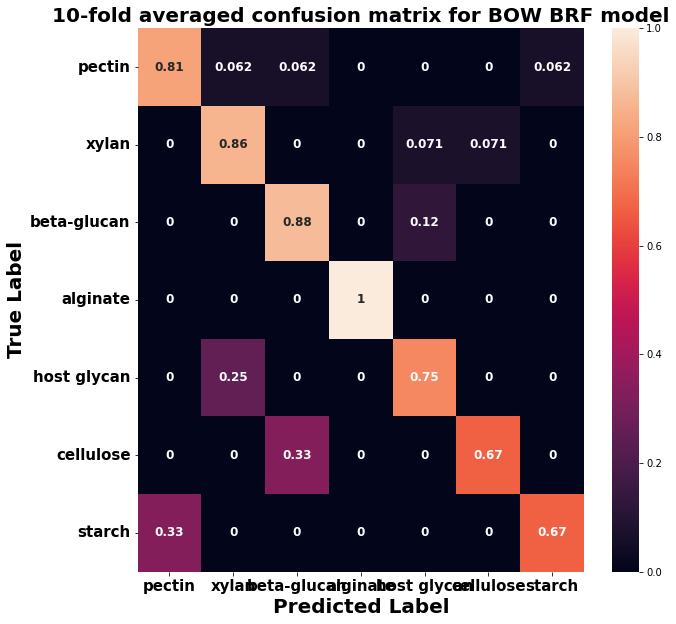

In [73]:
# make the plot
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df_cm, annot = True,  annot_kws={"fontsize":12, "weight":"bold"})
plt.title("10-fold averaged confusion matrix for BOW BRF model", fontsize = 20 ,weight = "bold")
plt.xlabel("Predicted Label",  weight = "bold", fontsize = 20)
plt.ylabel("True Label", weight = "bold", fontsize = 20)
plt.xticks(weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [74]:
imp_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, None)        0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, None, 300)    417000      ['text_vectorization[0][0]']     
                                                                                                  
 tanh_mlp (Dense)               (None, None, 150)    45150       ['embedding[0][0]']          

In [75]:
attention_out_model = tf.keras.models.Model(imp_model.input, imp_model.layers[7].output)

In [76]:
attention_out_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         417000    
                                                                 
 tanh_mlp (Dense)            (None, None, 150)         45150     
                                                                 
 dropout (Dropout)           (None, None, 150)         0         
                                                                 
 word-level_context (Dense)  (None, None, 1)           151       
                                                           

In [184]:
# correct_indexes = [i for i, item in enumerate(y_valid) if item in ['capsule polysaccharide synthesis', 'xylan']]

In [185]:
# xylan_cap_poly_seqs = X_valid[correct_indexes]

In [186]:
# xylan_cap_poly_target = y_valid[correct_indexes]

In [77]:
attention_scores = attention_out_model.predict(X_train, batch_size=1)

100/100 [==============================] - 1s 7ms/step


In [79]:
import numpy as np

In [83]:
scores.numpy()

array([2.2613365e-08, 2.2613365e-08, 2.2613365e-08, 2.2613365e-08,
       5.7281707e-03, 2.1572043e-06, 2.2613365e-08, 2.2613365e-08,
       2.2613365e-08, 4.7383966e-07, 2.2613365e-08, 1.2531517e-07,
       6.9783498e-05, 9.8667163e-01, 2.0570353e-08, 2.0570353e-08,
       2.0570353e-08, 5.7281707e-03, 1.7960897e-03, 4.6631644e-07,
       2.2613365e-08, 2.0570353e-08, 2.0570353e-08, 1.5486376e-07,
       5.5403785e-08, 5.5403785e-08, 2.5561576e-06], dtype=float32)

In [84]:
top_3_genes = []
top_3_scores = []
for idx, seq in enumerate(X_train): 
    genes = seq.split()
    genes = np.array(genes)
    scores = attention_scores[idx].numpy()
    order = scores.argsort()[::-1]
    top_3 = order[:3].tolist()
    genes_top_3 = genes[top_3]
    scores_top_3 = scores[top_3]
    top_3_scores.append(scores_top_3.tolist())
    top_3_genes.append(genes_top_3.tolist())

In [85]:
le.classes_

array(['alginate', 'beta-glucan', 'cellulose', 'host glycan', 'pectin',
       'starch', 'xylan'], dtype=object)

In [86]:
importances_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(le.inverse_transform(y_train)) , pd.DataFrame(top_3_genes),
           pd.DataFrame(top_3_scores)], 1, ignore_index = True)

C:\Users\vedpi\AppData\Local\Temp\ipykernel_23284\2100717927.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  importances_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(le.inverse_transform(y_train)) , pd.DataFrame(top_3_genes),


In [87]:
importances_df

,0,1,2,3,4,5,6,7
0,null null null null GH10 9.B.28 null null null...,xylan,GH67,GH10,GH10,0.986672,0.005728,0.005728
1,GH105 CE8 null CE12 CE8 AAA HTH_AraC null null...,pectin,PL1_2,PL1_2,CE12,0.467145,0.467145,0.064963
2,CBM67 GH78 null GH142 GH95 null CBM67 GH78 GH1...,pectin,PL1_2,PL1_2,PL1_2,0.329904,0.329904,0.329904
3,TrmB PL1_2 null PL1_5 PL1_5,pectin,PL1_2,PL1_5,PL1_5,0.960241,0.019864,0.019864
4,CE12 GH28 PL10_1 CE8 GH43_10 GH105 GH105 GH105...,pectin,CE12,GH28,GH28,0.860730,0.050340,0.050340
...,...,...,...,...,...,...,...,...
95,3.A.1 3.A.1 3.A.1 GH13_1 LacI Peripla_BP_3,starch,GH13_1,Peripla_BP_3,LacI,0.994238,0.005746,0.000005
96,3.A.1 3.A.1 3.A.1 3.A.1 HTH_12 null GH65 CBM34...,starch,8.A.9,HTH_12,GH13_20,0.999877,0.000119,0.000002
97,CBM3 cohesin cohesin cohesin cohesin cohesin c...,cellulose,GH5_1,cohesin,cohesin,0.998955,0.000148,0.000148
98,null null null null null null 1.B.14 null 2.A....,host glycan,GH20,GH20,GH20,0.333204,0.333204,0.333204


In [89]:
# importances_df.columns = ["cazymes_predicted_dbcan", "ground_truth_high_level_substrates" ,
#                          "first_most_imp_gene", "score_first_most_imp_gene"]

In [90]:
importances_df.columns = ["cazymes_predicted_dbcan", "ground_truth_high_level_substrates" ,
                         "first_most_imp_gene", "second_most_imp_gene", "third_most_imp_gene", 
                         "score_first_most_imp_gene", "score_second_most_imp_gene", "score_third_most_imp_gene"]

In [91]:
importances_df.head()

,cazymes_predicted_dbcan,ground_truth_high_level_substrates,first_most_imp_gene,second_most_imp_gene,third_most_imp_gene,score_first_most_imp_gene,score_second_most_imp_gene,score_third_most_imp_gene
0,null null null null GH10 9.B.28 null null null...,xylan,GH67,GH10,GH10,0.986672,0.005728,0.005728
1,GH105 CE8 null CE12 CE8 AAA HTH_AraC null null...,pectin,PL1_2,PL1_2,CE12,0.467145,0.467145,0.064963
2,CBM67 GH78 null GH142 GH95 null CBM67 GH78 GH1...,pectin,PL1_2,PL1_2,PL1_2,0.329904,0.329904,0.329904
3,TrmB PL1_2 null PL1_5 PL1_5,pectin,PL1_2,PL1_5,PL1_5,0.960241,0.019864,0.019864
4,CE12 GH28 PL10_1 CE8 GH43_10 GH105 GH105 GH105...,pectin,CE12,GH28,GH28,0.860730,0.050340,0.050340


In [1894]:
# importances_df.to_csv("signature_genes_with_scores_for_SOME_xylan_capsule_poly_sequences_for_train_set.csv", index = False)

In [111]:
first_story = importances_df.groupby(["ground_truth_high_level_substrates", "first_most_imp_gene"])["score_first_most_imp_gene"].aggregate({"count", "mean"})

In [113]:
first_story = first_story[["count", "mean"]]

In [114]:
first_story.columns = ["count_first_most_imp_gene", "avg_importance_score_first_most_imp_gene"]

In [115]:
first_story = first_story.reset_index()

In [116]:
first_story = first_story.sort_values(["ground_truth_high_level_substrates", "count_first_most_imp_gene", "avg_importance_score_first_most_imp_gene"], 
                       ascending = [True, False, False])

In [117]:
second_story = importances_df.groupby(["ground_truth_high_level_substrates", "second_most_imp_gene"])["score_second_most_imp_gene"].aggregate({"count", "mean"})

In [118]:
second_story = second_story[["count", "mean"]]

In [119]:
second_story.columns = ["count_second_most_imp_gene", "avg_importance_score_second_most_imp_gene"]

In [120]:
second_story = second_story.reset_index()

second_story = second_story.sort_values(["ground_truth_high_level_substrates", "count_second_most_imp_gene", "avg_importance_score_second_most_imp_gene"], 
                       ascending = [True, False, False])

In [121]:
third_story = importances_df.groupby(["ground_truth_high_level_substrates", "third_most_imp_gene"])["score_third_most_imp_gene"].aggregate({"count", "mean"})

In [122]:
third_story = third_story[["count", "mean"]]

In [123]:
third_story.columns = ["count_third_most_imp_gene", "avg_importance_score_third_most_imp_gene"]

In [124]:
third_story = third_story.reset_index()

third_story = third_story.sort_values(["ground_truth_high_level_substrates", "count_third_most_imp_gene", "avg_importance_score_third_most_imp_gene"], 
                       ascending = [True, False, False])

In [125]:
third_story

,ground_truth_high_level_substrates,third_most_imp_gene,count_third_most_imp_gene,avg_importance_score_third_most_imp_gene
4,alginate,PL6_1,6,0.010455
5,alginate,PL7,1,0.088627
3,alginate,PL5,1,0.001524
1,alginate,AraC_binding,1,0.000218
0,alginate,3.D.2,1,0.000122
...,...,...,...,...
62,xylan,GH43_29,1,0.000315
57,xylan,CBM6,1,0.000285
67,xylan,SBP_bac_1,1,0.000018
55,xylan,2.A.1,1,0.000005


In [126]:
first_second = first_story.merge(second_story, how = "left", left_on = ["ground_truth_high_level_substrates", "first_most_imp_gene"], 
                                             right_on = ["ground_truth_high_level_substrates", "second_most_imp_gene"])

In [127]:
first_second_third = first_second.merge(third_story, how = "left", left_on = ["ground_truth_high_level_substrates", "first_most_imp_gene"], 
                                             right_on = ["ground_truth_high_level_substrates", "third_most_imp_gene"])

In [1951]:
# first_second_third = first_second_third.fillna(0)

In [128]:
first_second_third["overall_count"] = first_second_third["count_first_most_imp_gene"] + first_second_third["count_second_most_imp_gene"].fillna(0) + first_second_third["count_third_most_imp_gene"].fillna(0)

In [129]:
first_second_third = first_second_third.sort_values(["ground_truth_high_level_substrates", "overall_count"],
                                                    ascending = [True, False])

In [130]:
first_second_third = first_second_third.reset_index(drop = True)

In [131]:
first_second_third.head()

,ground_truth_high_level_substrates,first_most_imp_gene,count_first_most_imp_gene,avg_importance_score_first_most_imp_gene,second_most_imp_gene,count_second_most_imp_gene,avg_importance_score_second_most_imp_gene,third_most_imp_gene,count_third_most_imp_gene,avg_importance_score_third_most_imp_gene,overall_count
0,alginate,PL17,7,0.901327,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1,alginate,PL6_1,1,0.962079,NaN,NaN,NaN,PL6_1,6.0,0.010455,7.0
2,alginate,PL7,2,0.670977,PL7,2.0,0.294312,PL7,1.0,0.088627,5.0
3,alginate,PL15_1,1,0.999727,PL15_1,1.0,0.156272,NaN,NaN,NaN,2.0
4,alginate,PL5_1,1,0.989198,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [109]:
# first_second_third.to_csv("summary_for_important_signature_genes_by_substrate.csv", index = False)

In [132]:
first_second_third

,ground_truth_high_level_substrates,first_most_imp_gene,count_first_most_imp_gene,avg_importance_score_first_most_imp_gene,second_most_imp_gene,count_second_most_imp_gene,avg_importance_score_second_most_imp_gene,third_most_imp_gene,count_third_most_imp_gene,avg_importance_score_third_most_imp_gene,overall_count
0,alginate,PL17,7,0.901327,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1,alginate,PL6_1,1,0.962079,NaN,NaN,NaN,PL6_1,6.0,0.010455,7.0
2,alginate,PL7,2,0.670977,PL7,2.0,0.294312,PL7,1.0,0.088627,5.0
3,alginate,PL15_1,1,0.999727,PL15_1,1.0,0.156272,NaN,NaN,NaN,2.0
4,alginate,PL5_1,1,0.989198,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,beta-glucan,GH3,6,0.745597,GH3,4.0,0.374986,NaN,NaN,NaN,10.0
6,beta-glucan,CBM4,2,0.590396,CBM4,1.0,0.249103,CBM4,1.0,0.249103,4.0
7,beta-glucan,null,1,0.729234,null,2.0,0.017104,null,1.0,0.000276,4.0
8,beta-glucan,GerE,1,0.927874,GerE,1.0,0.007543,NaN,NaN,NaN,2.0
9,beta-glucan,GH26,1,0.998254,NaN,NaN,NaN,NaN,NaN,NaN,1.0
